In [1]:
import cv2
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import random

In [2]:
name_line = {}
line_root = ET.parse('D:/Lab/ultrasound PTB/data/first_data/E2EPTB-codes/data/cervix_image_with_mask_and_bbox/scale_annotations.xml').getroot()
for image in line_root.findall('image'):
     pic_name = image.attrib['name']
     name = pic_name.split('_')[0]
     for anno in image:
        if anno.tag == 'polyline':
            arr = np.array(list(map(
                lambda x: np.array(x.strip().split(','), dtype=np.float32),
                anno.attrib['points'].split(';')
            )))
            name_line[name] = arr

line_root = ET.parse('D:/Lab/ultrasound PTB/data/first_data/E2EPTB-codes/data/cervix_image_with_mask_and_bbox/scale_annotations.xml').getroot()
for image in line_root.findall('image'):
    
     pic_name = image.attrib['name']
     name = pic_name.split('_')[0]
     for anno in image:
        if anno.tag == 'polyline':
            arr = np.array(list(map(
                lambda x: np.array(x.strip().split(','), dtype=np.float32),
                anno.attrib['points'].split(';')
            )))
            name_line[name] = arr

In [3]:
uuid_scale={}
scale_root = ET.parse('D:/Lab/ultrasound PTB/data/first_data/E2EPTB-codes/data/cervix_image_with_mask_and_bbox/scale_annotations.xml').getroot()
for image in scale_root.findall('image'):
    uuid = image.attrib['name'][:-4]
    for anno in image:
        if anno.tag == 'polyline':
            arr = np.array(list(map(
                lambda x: np.array(x.strip().split(','), dtype=np.float32),
                anno.attrib['points'].split(';')
            )))
            scale = arr[1][1]-arr[0][1]
            uuid_scale[uuid]=scale   
  


In [4]:

base_dir = 'D:/Lab/ultrasound PTB/data/first_data/E2EPTB-codes/data/cervix_image_with_mask_and_bbox/images/'
root = ET.parse('D:/Lab/ultrasound PTB/data/first_data/E2EPTB-codes/data/cervix_image_with_mask_and_bbox/annotations.xml').getroot()
name_df = pd.read_csv('D:/Lab/ultrasound PTB/data/first_data/E2EPTB-codes/data/uuid_name.csv',index_col=0)
info_df = pd.read_csv('D:/Lab/ultrasound PTB/data/first_data/E2EPTB-codes/data/yunzhou.csv',index_col=0)

# acquire the information needed
cervixs=[]
labels=[]
names=[]
uuids=[]
polygons=[]
boxes=[]
img_paths=[]
scales=[]
masks = []
lines = []
ARTs = []
fluffs = []
jls = []
xjbs = []
incompetences = []
anaemias = []
inflammations = []

Tts = []

Buns = []

Glus = []


name2uuid = {}


for image in root.findall('image'):
    flag=True
    path = image.attrib['name']
    img_path = os.path.join(base_dir, path)
    uuid = path.split('/')[-1][:-4]
    for anno in image:
        if anno.tag == 'box':
            xtl = round(float(anno.attrib['xtl']))
            ytl = round(float(anno.attrib['ytl']))
            xbr = round(float(anno.attrib['xbr']))
            ybr = round(float(anno.attrib['ybr']))
            box=np.array([xtl,ytl,xbr,ybr])
           
        elif anno.tag == 'polygon':
            polygon = np.array(list(map(
                lambda x: np.array(x.strip().split(','), dtype=np.float32),
                anno.attrib['points'].split(';')
            )))
            mask =  np.around(polygon).astype(np.int32)
            
    
    try:
        name = name_df.loc[uuid]['Source'] 
        name = name.split('/')[-1].split('_')[0]
    except:
        # print('Person not found')
        flag=False

    try:
        label = info_df.loc[name]['自发性早产诊断']
        # print(label)
    except:
        # print('Label not found')
        flag=False

    try:
        cervix = info_df.loc[name]['孕中期宫颈长度']
        if np.isnan(cervix):
           flag = False
        #    print(name)
    except:
        # print('Cervix not found')
        flag=False

    try:
        fluff = info_df.loc[name]['绒毛膜性']
        if np.isnan(fluff):
            flag = False
    except:
        flag = False

    try:
        art = info_df.loc[name]['ART']
        if np.isnan(art):
            flag = False
    except:
        flag = False

    try:
        jl = info_df.loc[name]['子宫肌瘤史']
        if np.isnan(jl):
            flag = False                    
    except:
        flag = False
    
    try:
        xjb = info_df.loc[name]['子宫腺肌病史']
        if np.isnan(xjb):
            flag = False
    except:
        flag = False

    try:
        incompetence = info_df.loc[name]['宫颈机能不全']
        if np.isnan(incompetence):
            flag = False
    except:
        flag = False

    try:
        Hb = info_df.loc[name]['Hb2']
        if np.isnan(Hb):
            flag = False
    except:
        flag = False

    try:
        Hct = info_df.loc[name]['Hct2']
        if np.isnan(Hct):
            flag = False
    except:
        flag = False
    
    try:
        Wbc = info_df.loc[name]['WBC2']
        if np.isnan(Wbc):
            flag = False
    except:
        flag = False

    try:
        Neut = info_df.loc[name]['NEUT2']
        if np.isnan(Neut):
            flag = False
    except:
        flag = False

    try:
        Bun = info_df.loc[name]['BUN1']
        if np.isnan(Bun):
            flag = False
    except:
        flag = False
    
    try:
        Tt = info_df.loc[name]['TT1']
        if np.isnan(Tt):
            flag = False
    except:
        flag = False

    try:
        Glu = info_df.loc[name]['GLU1']
        if np.isnan(Glu):
            flag = False
    except:
        flag = False

#******************************************************************************************
    scale = uuid_scale[uuid]

    if name in name_line:
        line = name_line[name]
    else:
        line = np.array([[-1,-1],[-1,-1]])

    name2uuid[name] = uuid+'.png' 
    
    if flag:
        cervixs.append(cervix)
        labels.append(label)
        names.append(name)
        uuids.append(uuid)
        polygons.append(polygon)
        boxes.append(box)
        img_paths.append(img_path)
        scales.append(scale)
        masks.append(mask)
        lines.append(line)
        ARTs.append(art)
        fluffs.append(fluff)
        jls.append(jl)
        xjbs.append(xjb)
        incompetences.append(incompetence)
        anaemias.append(Hb/Hct)
        inflammations.append(Neut/Wbc)
        Buns.append(Bun)
        Tts.append(Tt)
        Glus.append(Glu)

    
print(len(cervixs),len(names),len(labels))

230 230 230


In [5]:
#deal with four kinds of images
finished = 0
base_imgpath = 'D:/Lab/ultrasound PTB/data/first_data/E2EPTB-codes/data/cervix_image_with_mask_and_bbox/images/data/202106042205/output/'
base_maskpath = 'D:/Lab/ultrasound PTB/data/prediction_masks/'
predict_masks = []

for label,cervix,name in zip(labels,cervixs,names):
    uid = name2uuid[name]
    img = cv2.imread(base_imgpath+uid[:-4]+'.jpg')
    imgcan = np.zeros(img.shape)
    the_mask = cv2.imread(base_maskpath+uid)
    img_with_mask = img.copy()

    mask_save_path = 'D:/Lab/ultrasound PTB/data/data1/masks/'
    img_save_path = 'D:/Lab/ultrasound PTB/data/data1/images/'
    img_mask_save_path = 'D:/Lab/ultrasound PTB/data/data1/images_with_mask/'
    segment_path = 'D:/Lab/ultrasound PTB/data/data1/segmentation/'
    if label == 1:
        mask_save_path += 'preterm/'
        img_save_path += 'preterm/'
        img_mask_save_path += 'preterm/'
        segment_path += 'preterm/'
    else:
        mask_save_path += 'healthy/'
        img_save_path += 'healthy/'
        img_mask_save_path += 'healthy/'
        segment_path += 'healthy/'
    
    if not os.path.exists(mask_save_path):
        os.makedirs(mask_save_path)
    if not os.path.exists(img_save_path):
        os.makedirs(img_save_path) 
    if not os.path.exists(img_mask_save_path):
        os.makedirs(img_mask_save_path) 
    if not os.path.exists(segment_path):
        os.makedirs(segment_path) 

    mask_save_path += name + '_' +str(label)+'_'+str(cervix) +'.jpg'
    img_save_path += name + '_' + str(label) +'_' + str(cervix) +'.jpg'
    img_mask_save_path += name + '_' + str(label)+'_'+str(cervix) + '.jpg'
    segment_path += name + '_' + str(label) + '_' + str(cervix) + '.jpg'

    mat = np.full(img.shape,255)
    masked_img = mat-the_mask+img

    gray = cv2.cvtColor(the_mask,cv2.COLOR_BGR2GRAY)
    the_mask = the_mask.astype(np.uint8)
    contours,hierarchy = cv2.findContours(gray,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    area = []
    for k in range(len(contours)):
        area.append(cv2.contourArea(contours[k]))
    if len(area)==0:
        print(uid)
    max_idx = np.argsort(np.array(area))[-1]
    mask = contours[max_idx]    

    predict_masks.append(mask)

    cv2.polylines(img_with_mask,[mask],True,(0,255,255),2)
    # cv2.imencode('.jpg', img)[1].tofile(img_save_path) 
    # cv2.imencode('.jpg', img_with_mask)[1].tofile(img_mask_save_path) 
    # cv2.imencode('.jpg', the_mask)[1].tofile(mask_save_path) 
    # cv2.imencode('.jpg',masked_img)[1].tofile(segment_path)

    finished+=1
    print(finished,cv2.contourArea(mask) ,img.shape)
   


1 28000.0 (619, 604, 3)
2 50858.5 (576, 720, 3)
3 29331.0 (676, 605, 3)
4 82521.0 (768, 1024, 3)
5 65811.0 (768, 1024, 3)
6 65684.5 (768, 1024, 3)
7 74511.5 (852, 1136, 3)
8 38362.5 (576, 720, 3)
9 13388.5 (576, 720, 3)
10 40135.5 (576, 720, 3)
11 14516.5 (576, 720, 3)
12 43015.5 (676, 605, 3)
13 30744.5 (576, 720, 3)
14 22031.0 (576, 720, 3)
15 21903.5 (735, 975, 3)
16 13577.5 (576, 720, 3)
17 35176.0 (676, 605, 3)
18 23227.5 (735, 975, 3)
19 18406.5 (511, 719, 3)
20 1713.5 (852, 1136, 3)
21 33610.5 (576, 720, 3)
22 10698.0 (576, 720, 3)
23 60072.5 (872, 1280, 3)
24 15743.5 (576, 720, 3)
25 27703.0 (576, 720, 3)
26 41109.5 (576, 720, 3)
27 49733.0 (956, 1097, 3)
28 23032.0 (676, 605, 3)
29 37313.0 (576, 720, 3)
30 29320.0 (600, 720, 3)
31 39598.0 (576, 720, 3)
32 19411.5 (676, 605, 3)
33 20272.5 (619, 604, 3)
34 15134.5 (676, 605, 3)
35 43312.5 (768, 1024, 3)
36 75061.5 (768, 1024, 3)
37 20638.0 (676, 605, 3)
38 15425.0 (600, 720, 3)
39 8732.0 (600, 720, 3)
40 30645.5 (676, 605, 3)
41

In [50]:
#deal with black area
finished = 0
black_areas = []
black_percents = []

for img_path,mask,label,cervix,name,scale in zip(img_paths,predict_masks,labels,cervixs,names,scales):
    img = cv2.imread(img_path)
    the_mask = np.zeros(img.shape, dtype=np.float32)
    cv2.fillPoly(the_mask, [mask], (255,255,255))
    thr_black_path = 'D:/Lab/ultrasound PTB/data/data1/thresholding_blackarea/'
    if label == 1:
        thr_black_path += 'preterm/'
    else:
       thr_black_path += 'healthy/'
    
    if not os.path.exists(thr_black_path):
        os.makedirs(thr_black_path) 

    thr_black_path += name + '_' + str(label) + '_' + str(cervix) + '.jpg'

    #segment the image with mask
    mat = np.full(img.shape,255)
    masked_img = mat-the_mask+img
    masked_img = np.minimum(masked_img,255)
    masked_img = masked_img.astype(np.float32)

    #binary the mask image
    gray = cv2.cvtColor(masked_img,cv2.COLOR_BGR2GRAY)
    ret,thr_black_area = cv2.threshold(gray,80,255,cv2.THRESH_BINARY_INV)

    #Find contours in the thr_black_area
    thr_black_area = thr_black_area.astype(np.uint8)
    contours,hierarchy = cv2.findContours(thr_black_area,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    area = []
    for k in range(len(contours)):
        area.append(cv2.contourArea(contours[k]))
    max_idx = np.argsort(np.array(area))[-1]

    canvas = np.full(img.shape,255)
    black_area = cv2.drawContours(canvas,contours,max_idx,0,-1)
    
    black_cnt = cv2.contourArea(contours[max_idx])
    mask_cnt = cv2.contourArea(mask)
    
    print('Black_cnt:{}, Mask_cnt:{}, Black Percent:{:.3f}, Label:{}'.format(black_cnt/scale/scale,mask_cnt,black_cnt/mask_cnt,label))

    black_percents.append(black_cnt/mask_cnt)
    black_areas.append(black_cnt/scale/scale)

    cv2.imencode('.jpg',black_area)[1].tofile(thr_black_path)
    finished += 1
    print(finished)


Black_cnt:1.6611235494803154, Mask_cnt:28000.0, Black Percent:0.159, Label:1
1
Black_cnt:0.07942996764580013, Mask_cnt:50858.5, Black Percent:0.006, Label:0
2
Black_cnt:9.00896301710674, Mask_cnt:29331.0, Black Percent:0.853, Label:1
3
Black_cnt:12.159120592091767, Mask_cnt:82521.0, Black Percent:0.805, Label:1
4
Black_cnt:5.357415925290761, Mask_cnt:65811.0, Black Percent:0.433, Label:0
5
Black_cnt:0.8900126978090019, Mask_cnt:65684.5, Black Percent:0.073, Label:1
6
Black_cnt:1.6000799584723189, Mask_cnt:74511.5, Black Percent:0.140, Label:0
7
Black_cnt:3.499102460407711, Mask_cnt:38362.5, Black Percent:0.242, Label:0
8
Black_cnt:2.3654759490485655, Mask_cnt:13388.5, Black Percent:0.199, Label:0
9
Black_cnt:4.549856518544527, Mask_cnt:40135.5, Black Percent:0.372, Label:1
10
Black_cnt:3.287709550860495, Mask_cnt:14516.5, Black Percent:0.442, Label:1
11
Black_cnt:1.695917353557268, Mask_cnt:43015.5, Black Percent:0.105, Label:1
12
Black_cnt:1.4630996890613368, Mask_cnt:30744.5, Black P

In [23]:
#deal with the concavity
finished = 0
conc_extents = []
diameters = []
min_diameters = []

def outerProduct(a,b):
    return abs(a[0]*b[1]-a[1]*b[0])

def Dis(a,b):
    return ((a[0]-b[0])**2 + (a[1]-b[1])**2)**0.5

for img_path,mask,label,cervix,name,scale in zip(img_paths,predict_masks,labels,cervixs,names,scales):
    img = cv2.imread(img_path)
    convhull = np.zeros(img.shape,dtype=np.float32)

    
    #mask面积与凸包面积的比值  
    hull = cv2.convexHull(mask)
    cv2.fillPoly(convhull,[hull],(255,255,255))

    diameter = 0
    min_diameter = 19260817
    hull = hull.reshape(len(hull),2)
    length = int(len(hull))
    tag = 1
    for i in range(length):
        while outerProduct(hull[tag]-hull[(i+1)%length],hull[i]-hull[(i+1)%length]) < outerProduct(hull[(tag+1)%length]-hull[(i+1)%length],hull[i]-hull[(i+1)%length]):
            tag = (tag+1)%length
            
        diameter = max(diameter,max(Dis(hull[tag],hull[(i+1)%length]),Dis(hull[tag],hull[i])))
        #diameter = max(diameter,max(Dis(hull[(tag+1)%length],hull[(i+1)%length]),Dis(hull[(tag+1)%length],hull[i])))

        min_diameter = min(min_diameter,min(Dis(hull[tag],hull[(i+1)%length]),Dis(hull[tag],hull[i])))
        min_diameter = min(min_diameter,min(Dis(hull[(tag+1)%length],hull[(i+1)%length]),Dis(hull[(tag+1)%length],hull[i])))

    origin_area = cv2.contourArea(mask)
    convhull_area = cv2.contourArea(hull)

    conc_extent = (-origin_area+convhull_area)/scale/scale
    diameter = diameter/scale
    min_diameter = min_diameter/scale
    print(diameter,min_diameter)
    conc_extents.append(conc_extent)
    diameters.append(diameter)
    min_diameters.append(min_diameter)
    
    '''

    #在任意两个点之间连一条线得到的“点包”,mask面积与点包面积的比值
    origin_area = cv2.contourArea(mask)
    max_area = 0
    smax_area = 0
    concav_completion = mask
    singlehull_area = 0
    for  i in range(0,len(mask)):
        for j in range(i+2,len(mask)):
            completion = mask.tolist()
            del completion[i+1:j]
            completion = np.array(completion)

            singlehull_area = cv2.contourArea(completion)
            if singlehull_area>max_area:
                smax_area = max_area
                max_area = singlehull_area
            elif singlehull_area>smax_area:
                smax_area = singlehull_area
                

            #another orientation
            completion = mask.tolist()
            completion = completion[i+1:j]
            completion = np.array(completion)

            singlehull_area = cv2.contourArea(completion)
            if singlehull_area>max_area:
                smax_area = max_area
                max_area = singlehull_area
            elif singlehull_area>smax_area:
                smax_area = singlehull_area
    conc_extent = (smax_area+max_area-2*origin_area)/scale/scale
    print(label,conc_extent)
    conc_extents.append(conc_extent)
    '''

    '''cv2.fillPoly(convhull,[concav_completion],(255,255,255))
    
    singlehull_path = 'D:/Lab/ultrasound PTB/data/data1/singlehull/'

    if not os.path.exists(singlehull_path):
        os.makedirs(singlehull_path)

    singlehull_path += name + '_' + str(label) + '_' + str(cervix) + '.jpg'
    cv2.imencode('.jpg',convhull)[1].tofile(singlehull_path)'''
    
    finished+=1
    #print(finished)
print(len(diameters))

5.032732146689233 3.3756714737463334
5.384230284317147 4.167789126359545
5.402607594700482 2.3846339769908527
5.878006198539734 4.118872127795519
5.269668772100763 2.7547780827749335
5.031988439556549 3.517888343455681
4.9408837906362955 3.728958732369194
5.165266002732059 3.543408967055694
5.094900339131007 4.005117615981263
4.942339094019267 4.047962613289049
4.877914438737214 2.525539751698271
5.453894133235339 4.575357690138287
5.189191726708841 4.179892096522921
5.62099857676552 0.5942432162002357
6.956648283188071 2.59059673775709
5.495853691115976 3.0539387421259785
5.074873162881236 3.672861475026755
4.723799752308024 2.7358946536412745
5.23355940144521 2.3494432822038442
1.5405455119433458 0.7305933018821256
5.072301060176804 3.8376188460091876
4.3417105564545855 2.204240709585114
4.948082879917346 3.6553363074304945
5.676007752290458 3.0538095524894335
4.198731238932738 2.7196182100308515
5.02121241766752 2.919518971395789
5.227225665602098 3.1565163426283394
4.78635879397774

In [8]:
#Area and Perimeter
finished = 0
Areas = []
Perimeters = []

for img_path,mask,scale in zip(img_paths,predict_masks,scales):
    img = cv2.imread(img_path)
    the_mask = np.zeros(img.shape,dtype=np.float32)
    Area = cv2.contourArea(mask)
    Perimeter = cv2.arcLength(mask,True)

    Perimeters.append(Perimeter/scale)
    Areas.append(Area/scale/scale)
    
print(len(Areas),len(Perimeters))

230 230


In [9]:
dia_shapes = [diameters[i]/min_diameters[i] for i in range(len(diameters))]

(230, 16)
Train:
0.7653


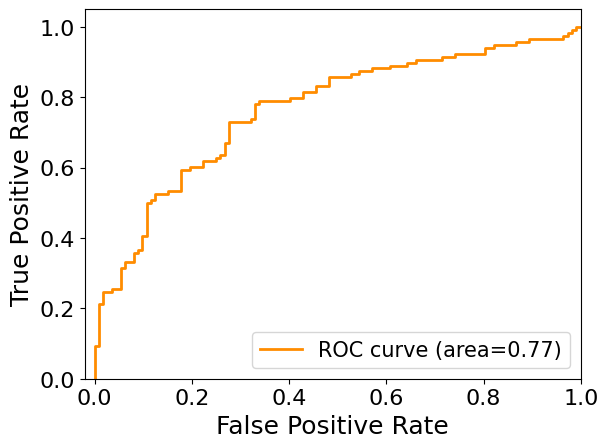

In [21]:
#回归


def print_result(y_pred,y_test):
    fpr, tpr, _ = roc_curve(y_test,y_pred)
    roc_auc = auc(fpr, tpr)
    print('{:.4f}'.format(roc_auc))
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area=%0.2f)' % roc_auc)
   
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.tick_params(labelsize=16)
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    #plt.title('ROC curve',fontsize=20)
    plt.legend(loc="lower right",fontsize=15)
    plt.show()
    return roc_auc
    


def train_and_test(need_test):
    if need_test:
        seed = random.randint(0,1000000)
        test_size=0.2
      
        x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=test_size,random_state=seed,stratify=y)
    else:
        x_train,y_train = x,y


    model = LogisticRegression(max_iter=2000)
    model.fit(x_train,y_train)
    train_pred=model.predict_proba(x_train)[:,1]
    print("Train:")
    print_result(train_pred,y_train)
    if need_test:
        y_pred=model.predict_proba(x_test)[:,1]     
        print("Test:")
        print_result(y_pred,y_test)


features = [list(t) for t in zip(conc_extents,diameters,min_diameters,black_areas,black_percents,Areas,ARTs,fluffs,jls,xjbs,incompetences,anaemias,inflammations,Tts,Buns,Glus)]
# features = [list(t) for t in zip(conc_extents,diameters,min_diameters,black_areas,black_percents,Areas)]
# features = [list(t) for t in zip(Areas)]
features = np.array(features)
x = np.array(features,dtype=np.float32)
y = np.array(labels,dtype=np.float32)
#x = np.reshape(x,(-1,1))

print(x.shape)
train_and_test(False)

8/8 [==============================] - 0s 1ms/step - loss: 0.5818 - auc: 0.7664
Accuracy:0.766419529914856
8/8 [==============================] - 0s 857us/step
0.7659


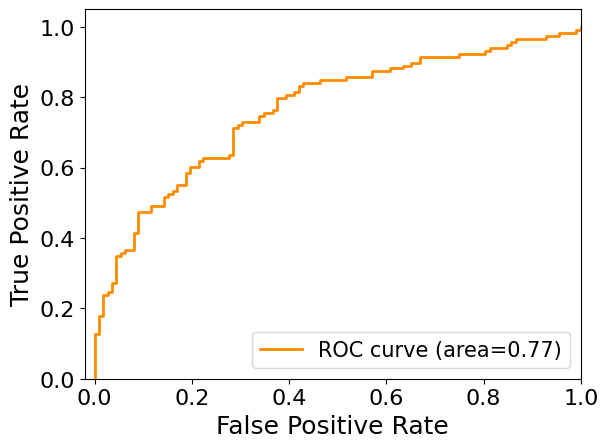

0.7658898305084746

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

tf_model = Sequential()
tf_model.add(Dense(1,input_dim=16,activation='sigmoid'))

tf_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['AUC'])

tf_model.fit(x,y,epochs=10000,verbose=0)

loss,acc = tf_model.evaluate(x,y)
print(f'Accuracy:{acc}')

y_pred = tf_model.predict(x)
print_result(y_pred,y)

In [49]:
layer = tf_model.layers[0]
weights = layer.get_weights()
lis = []
#print(weights[0][1][0])
for i in range(16):
    lis.append(weights[0][i][0])
# print(weights[1][0])
lis.append(weights[1][0])
print(lis)

[0.35214043, -0.21649033, 0.046375435, 0.18832417, -2.1727402, -0.20538525, 0.7553606, 1.3897735, 1.723469, 1.1357573, 2.9172645, -0.010626171, 0.12641433, 0.12422553, 0.06690673, 0.36758995, -0.90298194]
